In [66]:
from pathlib import Path
from typing import List
import logging
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

def extract_param_from_string(string, param: str) -> str:
    """
    Extract parameter values from string using regex.
    Returns a dict {param: value}
    """
    # Match param=<anything>, (comma required after value)
    match = re.search(rf"{param}=([^,]+),", string)
    if match:
        return match.group(1)
    else: 
        return "not found"

def get_grid_search_dirs(results_directory, results_subdir_identifier, dir_ids):
    """
    Find all subdirectories in results_directory (recursively) whose names contain
    results_subdir_identifier and all strings in dir_ids.
    Returns a list of Path objects.
    """
    subdirs = results_directory.rglob("*")
    print(
        f"Searching in {results_directory} for subdirectories containing '{results_subdir_identifier}' and {dir_ids}"
    )
    print(f"Found {len(list(subdirs))} subdirectories in total.")

    matching_dirs = []
    subdirs = results_directory.rglob("*")
    for subdir in subdirs:
        if not subdir.is_dir():
            continue
        name = subdir.name
        if results_subdir_identifier in name and all(did in name for did in dir_ids):
            print(f"Matched directory: {subdir}")
            matching_dirs.append(subdir)
    return matching_dirs

def create_grid_search_data(dir_list, results_name, params_to_track):
    """
    Given a list of pathlib.Path objects (directories), load the CSV file named <results_name>.csv
    from each directory and concatenate them into a single pandas DataFrame.
    Returns the concatenated DataFrame.
    params_to_track is a list of parameters to track in the DataFrame.
    They are contained in the directory names
    """
    dataframes = []
    for d in dir_list:
        csv_path = d / f"{results_name}.csv"
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            df['source_dir'] = str(d)  # Optionally track source directory
            for param in params_to_track:
                param_value = extract_param_from_string(str(d), param)
                df[param] = param_value
            dataframes.append(df)
        else:
            logging.warning(f"CSV file not found: {csv_path}")
    if dataframes:
        return pd.concat(dataframes, ignore_index=True)
    else:
        return pd.DataFrame()


def xy_grid_plot(data, group_name, x_par, y_par, c_pars):
    data[group_name] = data[group_name].astype(int)
    groups = data.sort_values(group_name).groupby(group_name)
    cpar_min = data[c_pars].values.min()
    cpar_max = data[c_pars].values.max()
    x_lim = (data[x_par].min() - data[x_par].min()/50, data[x_par].max()+ data[x_par].max()/50)
    y_lim = (data[y_par].min() - data[y_par].min()/50, data[y_par].max()+ data[y_par].max()/50)
    for group_id, group in groups:
        avg = group.groupby([x_par, y_par])[c_pars].mean().reset_index()
        fig, axes = plt.subplots(1, len(c_pars), figsize=(5 * len(c_pars), 5), sharex=True, sharey=True)
        if len(c_pars) == 1:
            axes = [axes]
        for ax, c_par in zip(axes, c_pars):
            norm = plt.Normalize(cpar_min, cpar_max)
            # Map color for each point using normalized value
            colors = plt.cm.Spectral(norm(avg[c_par].values))
            scatter = ax.scatter(
                avg[x_par], avg[y_par], c=colors, s=500
            )
            ax.set_title(f"{c_par} (H={group_id})")
            ax.set_xlim(x_lim)
            ax.set_ylim(y_lim)
            ax.set_xlabel(x_par)
            ax.set_ylabel(y_par)
            # Create a colorbar with the same normalization
            sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax)
            cbar.set_label(c_par)
        plt.tight_layout()
        plt.show()

## Threshold values optimization

In [68]:
# the directory containing the results
results_directory = Path("../multirun/baseline_tuning")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = ["threshold"]
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)

data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data

Searching in ../multirun/baseline_tuning for subdirectories containing 'cfg' and ['threshold']
Found 8035 subdirectories in total.
Matched directory: ../multirun/baseline_tuning/2025-05-30-18-46-11/cfg:+threshold_hidden_values=[0.5,0.75,1.0],+threshold_readout_values=[2.5,3.0,3.5,4.0],H=300,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-05-30-18-46-11/cfg:+threshold_hidden_values=[0.5,0.75,1.0],+threshold_readout_values=[2.5,3.0,3.5,4.0],H=1000,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-05-30-18-46-11/cfg:+threshold_hidden_values=[0.5,0.75,1.0],+threshold_readout_values=[2.5,3.0,3.5,4.0],H=3000,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-05-30-18-44-11/cfg:+threshold_hidden_values=[0.5,0.75,1.0],+threshold_readout_values=[2.5,3.0,3.5,4.0],H=300,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-05-30-18-44-11/cfg:+threshold_hidden_values=[0.5,0.75,1.0],+threshold_readout_values=[2.5,3.0,3.5,4.0],H=1000,device=cuda
M

Matched directory: ../multirun/baseline_tuning/2025-06-02-20-32-08/cfg:+threshold_hidden_values=[1.25,1.5,2.0],+threshold_readout_values=[3.0,3.5],H=400,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-06-02-20-32-08/cfg:+threshold_hidden_values=[1.25,1.5,2.0],+threshold_readout_values=[3.0,3.5],H=1600,device=cuda
Matched directory: ../multirun/baseline_tuning/2025-06-02-20-32-08/cfg:+threshold_hidden_values=[1.25,1.5,2.0],+threshold_readout_values=[3.0,3.5],H=3200,device=cuda


,threshold_hidden,threshold_readout,max_train_acc,final_train_acc,max_eval_acc,final_eval_acc,source_dir,H
0,0.50,2.5,0.749117,0.552183,0.7501,0.5541,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
1,0.50,3.0,0.753767,0.565200,0.7530,0.5592,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
2,0.50,3.5,0.748083,0.543333,0.7475,0.5417,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
3,0.50,4.0,0.753800,0.547883,0.7580,0.5416,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
4,0.75,2.5,0.829300,0.822400,0.8089,0.8042,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
5,0.75,3.0,0.829633,0.826083,0.8072,0.8028,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
6,0.75,3.5,0.825300,0.824683,0.8053,0.8037,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
7,0.75,4.0,0.828500,0.828500,0.8099,0.8099,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
8,1.00,2.5,0.844150,0.840667,0.8270,0.8216,../multirun/baseline_tuning/2025-05-30-18-46-1...,300
9,1.00,3.0,0.847233,0.845733,0.8324,0.8270,../multirun/baseline_tuning/2025-05-30-18-46-1...,300


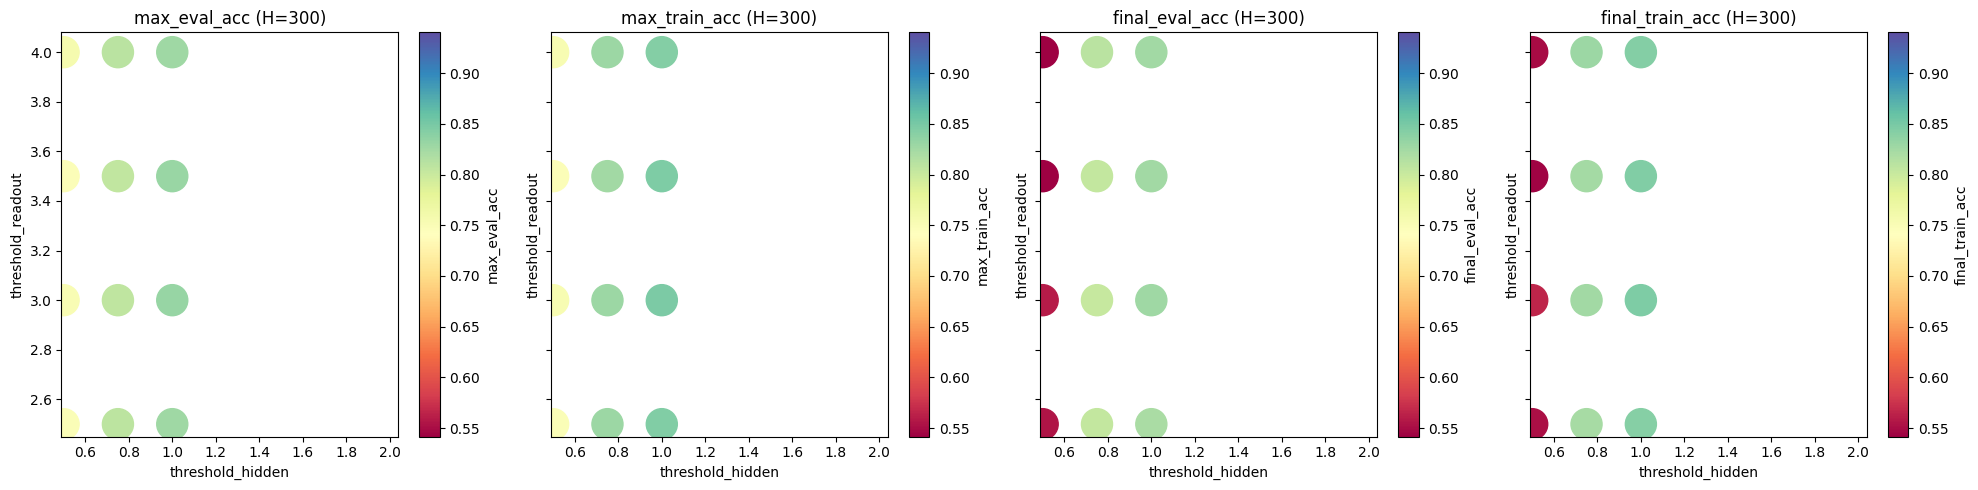

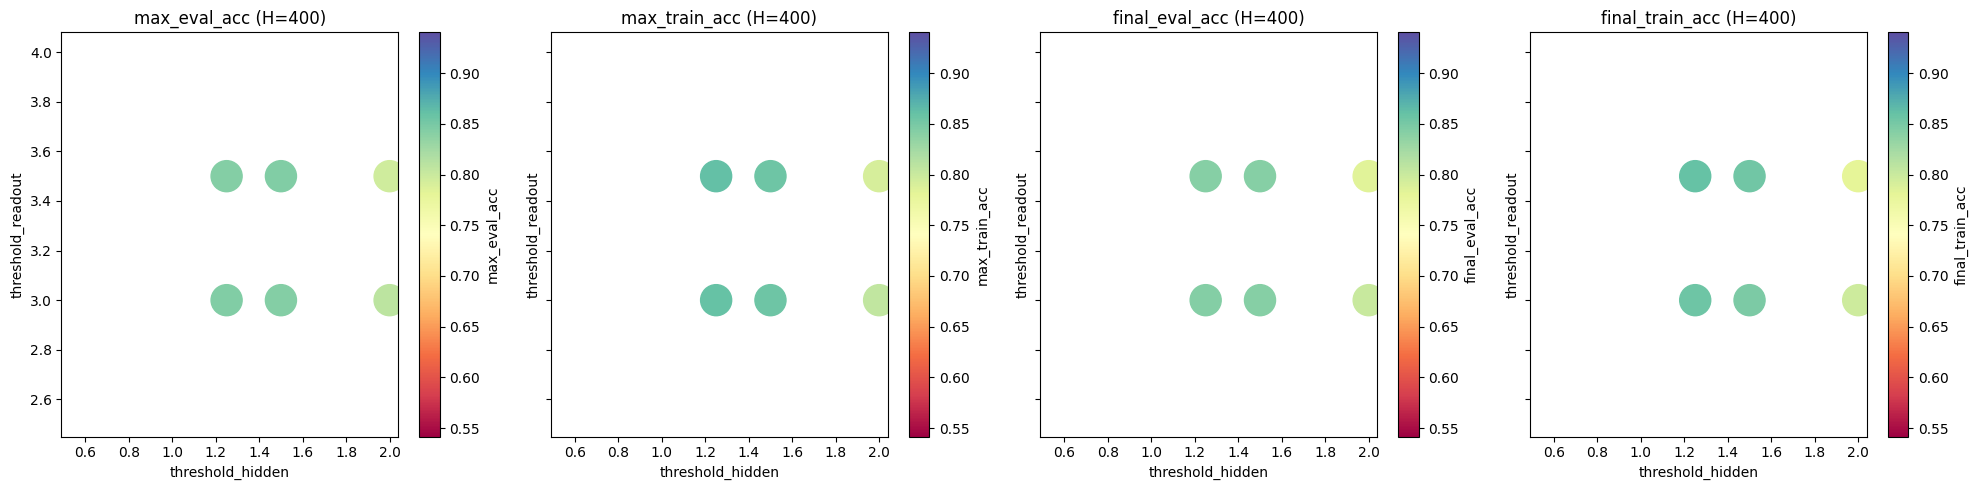

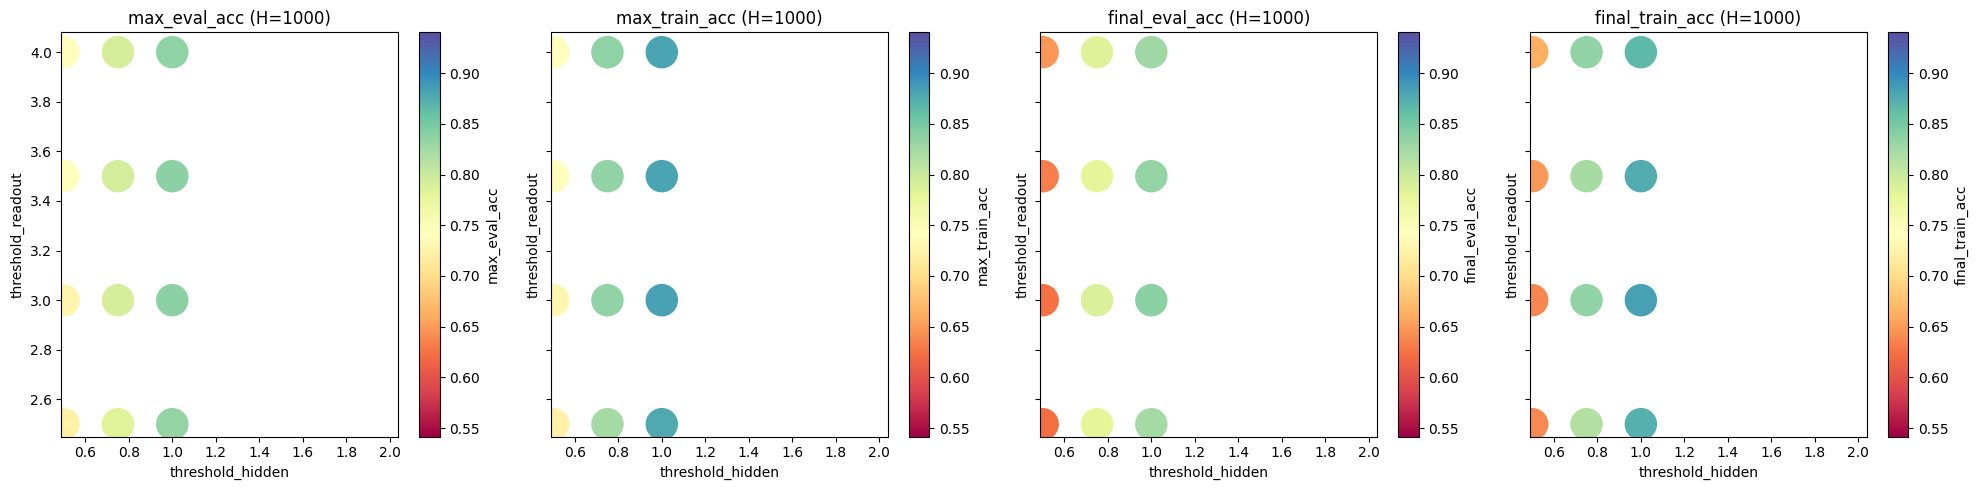

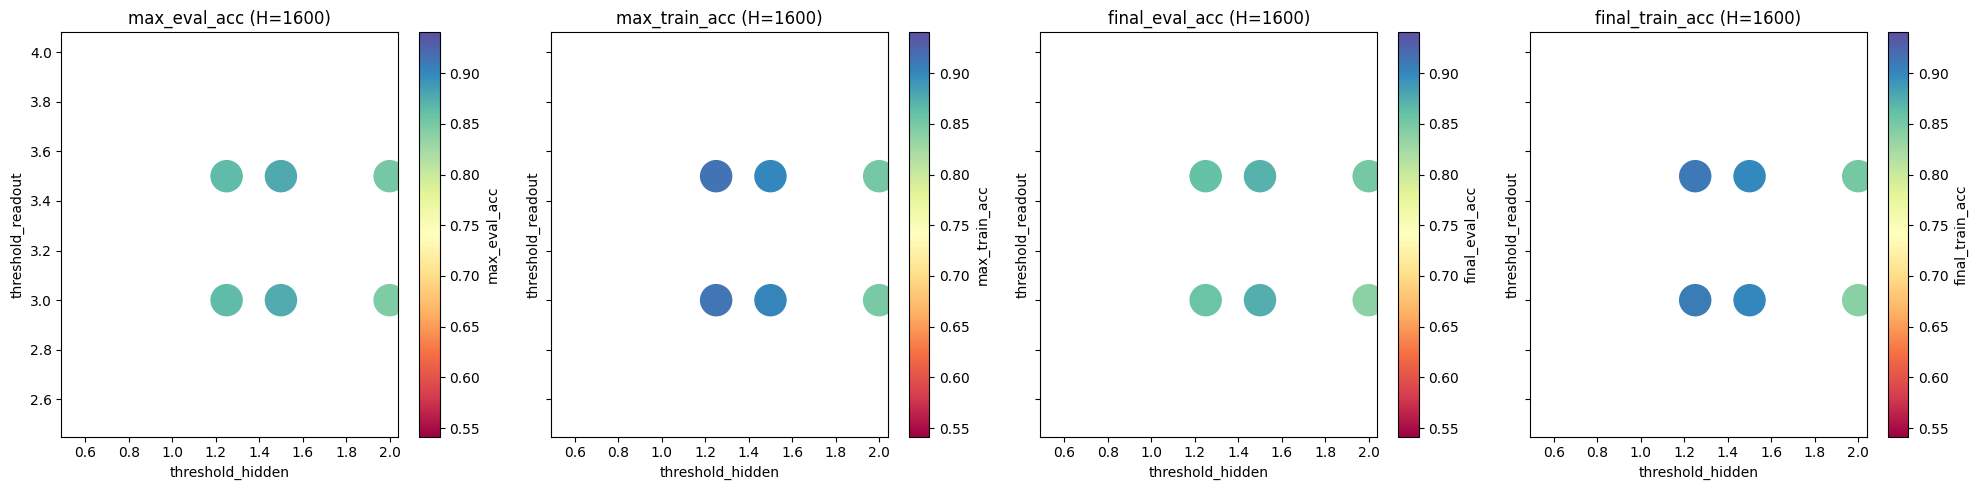

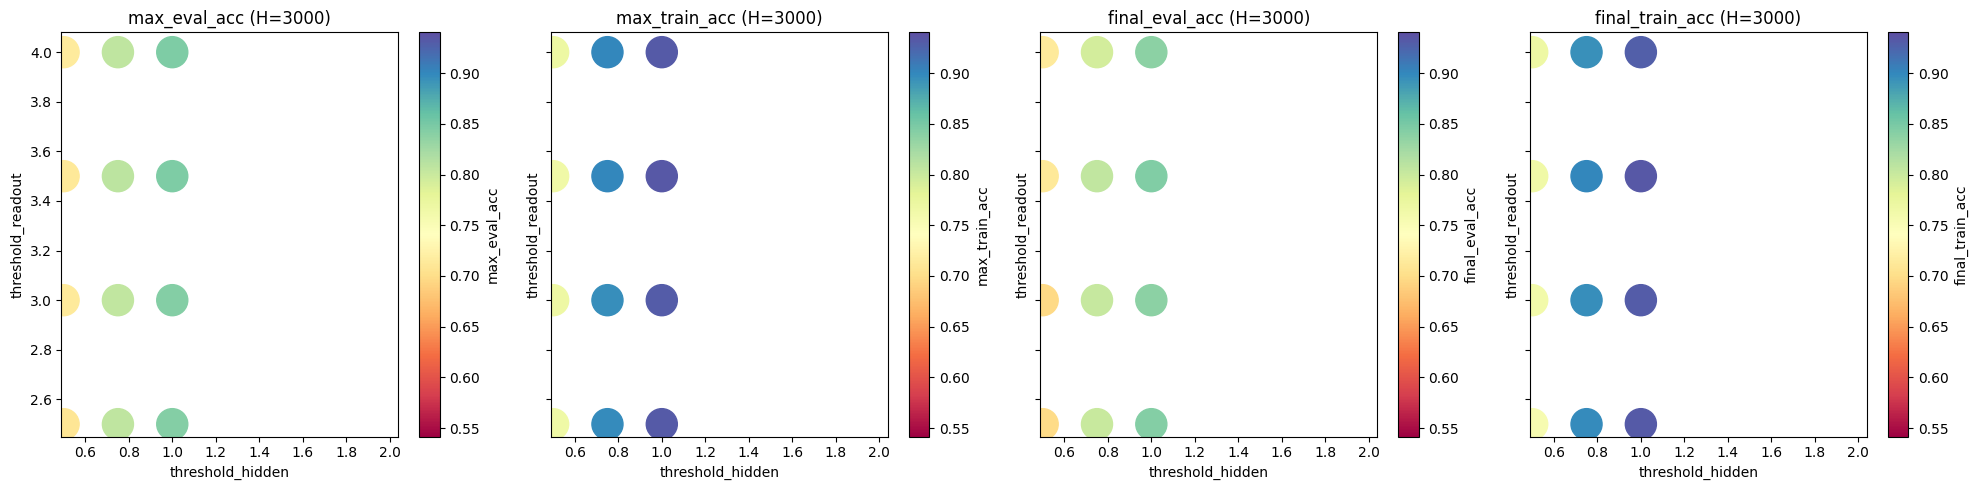

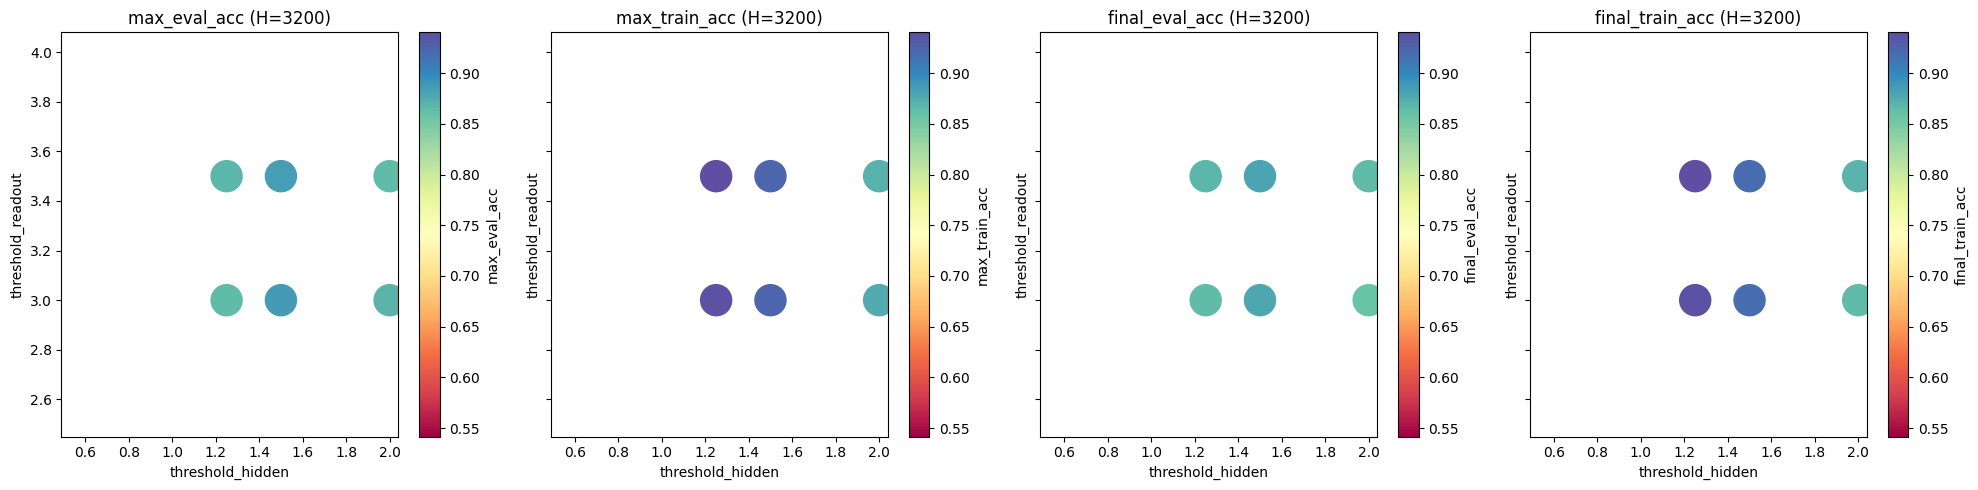

In [69]:
group_name = "H"
x_par = "threshold_hidden"
y_par = "threshold_readout"
c_pars = [
    "max_eval_acc",
    "max_train_acc",
    "final_eval_acc",
    "final_train_acc",
]
xy_grid_plot(
    data,
    group_name,
    x_par,
    y_par,
    c_pars
)

## Lambdas optimization

In [70]:
# the directory containing the results
results_directory = Path("../multirun/baseline_tuning")
# a string that identifies the directory containing a whole grid search
results_subdir_identifier = "cfg"
# only the subdirs that contain all these strings will be considered
dir_ids = ["lambda", "epochs"]
# parameters in the name of the subdirectory to track
name_params = ["H"]
# name of the CSV containing the results
results_name = "grid_search_results"

grid_search_directories = get_grid_search_dirs(
    results_directory,
    results_subdir_identifier,
    dir_ids
)

data = create_grid_search_data(
    grid_search_directories,
    results_name, 
    name_params
)
data = data.dropna(axis="index", how="any")
data

Searching in ../multirun/baseline_tuning for subdirectories containing 'cfg' and ['lambda', 'epochs']
Found 8035 subdirectories in total.
Matched directory: ../multirun/baseline_tuning/2025-06-04-10-37-12/cfg:+lambda_input_skip_values=[2.0,1.5,1.0,0.5,0.3],+lambda_wback_values=[1.0,1.5],H=400,device=cuda,num_epochs=100
Matched directory: ../multirun/baseline_tuning/2025-06-03-17-55-41/cfg:+lambda_input_skip_values=[2.0,1.5,1.0,0.5,0.3],+lambda_wback_values=[0.5,0.6,0.8],H=400,device=cuda,num_epochs=100
Matched directory: ../multirun/baseline_tuning/2025-06-04-11-42-18/cfg:+lambda_wback_values=[1.0,1.5],H=3200,device=cuda,num_epochs=100


,lambda_wback,lambda_input_skip,max_train_acc,final_train_acc,max_eval_acc,final_eval_acc,source_dir,H
0,1.0,2.0,0.841983,0.827717,0.8323,0.8124,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
1,1.0,1.5,0.845183,0.831317,0.8374,0.8148,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
2,1.0,1.0,0.840067,0.833283,0.8340,0.8196,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
3,1.0,0.5,0.838700,0.830833,0.8311,0.8212,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
4,1.0,0.3,0.837800,0.835017,0.8335,0.8223,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
5,1.5,2.0,0.780967,0.648900,0.7807,0.6419,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
6,1.5,1.5,0.781767,0.710867,0.7780,0.7047,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
7,1.5,1.0,0.773467,0.649383,0.7808,0.6472,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
8,1.5,0.5,0.774450,0.611967,0.7778,0.6135,../multirun/baseline_tuning/2025-06-04-10-37-1...,400
9,1.5,0.3,0.774750,0.596517,0.7759,0.6016,../multirun/baseline_tuning/2025-06-04-10-37-1...,400


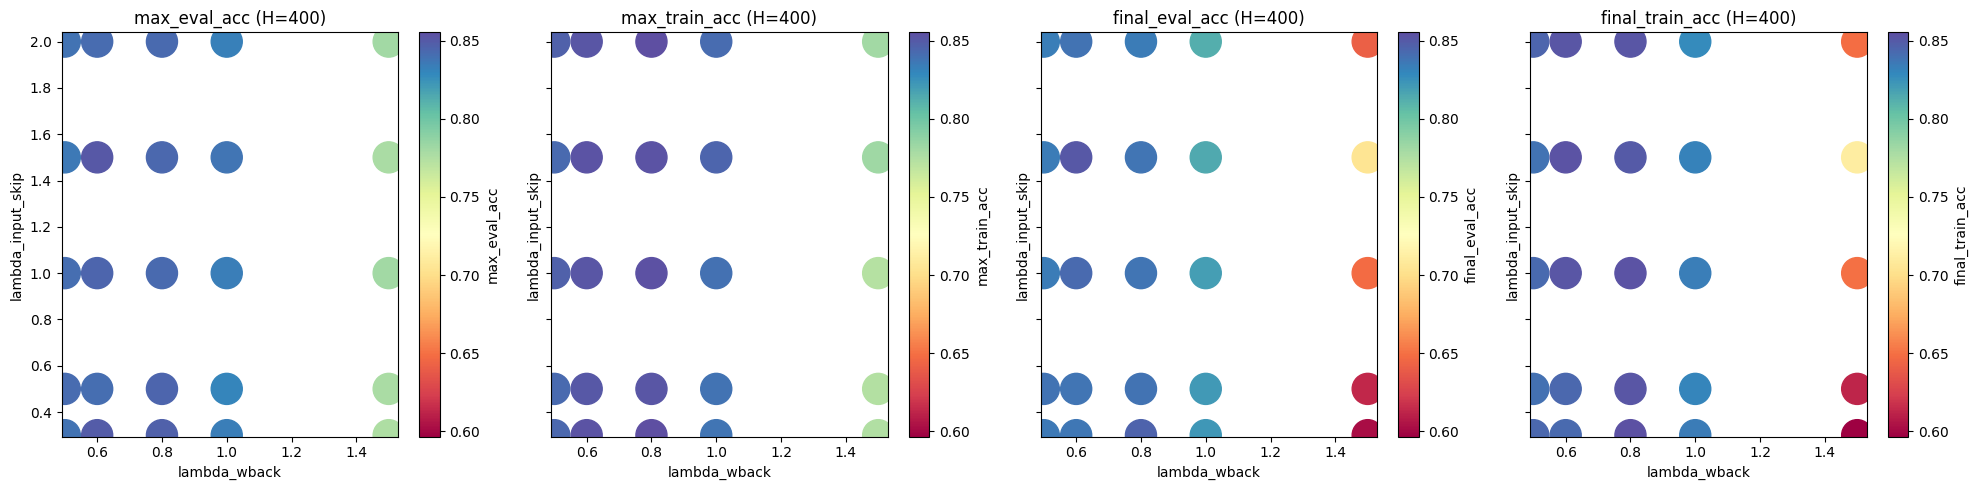

In [71]:
group_name = "H"
x_par = "lambda_wback"
y_par = "lambda_input_skip"
c_pars = [
    "max_eval_acc",
    "max_train_acc",
    "final_eval_acc",
    "final_train_acc",
]
xy_grid_plot(
    data,
    group_name,
    x_par,
    y_par,
    c_pars
)